In [1]:
!pip install konlpy
!pip install soynlp
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.4 MB/s 
     |████████████████████████████████| 453 kB 43.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 416 kB 4.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.4 MB/s 
     |████████████████████████████████| 6.6 MB 36.2 MB/s 
     |████████████████████████████████| 596 kB 53.2 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import pandas as pd
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from tensorflow.keras.models import load_model
from konlpy.tag import Hannanum
import matplotlib.pyplot as plt

In [3]:
youtube_df = pd.read_csv("labeled_youtube_0605.csv", lineterminator='\n')
youtube_df[:50]

FileNotFoundError: ignored

In [ ]:
# # 각각의 .csv파일의 df를 df_list안에 append해줍니다

# youtube_df.rename(columns = {'likes\r':'likes'}, inplace = True) # 저는 파일을 읽어오면 likes\r로 columns가 나와서 에러가 나나 싶어소 혹시 바꾸어줬습니다.

In [ ]:
youtube_df.info()

In [ ]:
youtube_df

,car_brand,car_model,comments,likes,related
0,BMW,1시리즈,"주제선정 좋아요. 더운 여름 잘 지내세요. 비싼차, 싼차, 슈퍼카, 경차 가리지 않...",3,1
1,BMW,1시리즈,주차장 시승평 잘봤네요ㅋ 그냥 외관이랑 실내평만 보면 편안할듯ㅋㅋ 매력적인 차네요 ...,3,1
2,BMW,1시리즈,차 가격도 싸고 디자인도 예쁘고 엄청 좋다,5,1
3,BMW,1시리즈,좀 끄럽다 하셨는데 G30 5시리즈랑 어느정도 차이가 날까요? ㅎㅎ,2,1
4,BMW,1시리즈,그나마 전륜으로 바뀌면서 공간이 좀 쓸만해 졌죠. 이전세대 1시리즈는 정말.... ...,2,1
...,...,...,...,...,...
207884,혼다,파일럿,"파일럿 오너입니다. 패밀리카로는 정말 최고 입니다. 넓은공간, 조용하고 묵직한 주행...",3,1
207885,혼다,파일럿,제가 아는 현대차 카마스터님과 말투가 너무 비슷하시네요~ 파일럿 최고죠^^ 할인해줬...,2,1
207886,혼다,파일럿,혼다 변속기 버튼은 헷갈리지않습니다. 직관적입니다. 현대 전자식 변속기가 배워야할 ...,4,1
207887,혼다,파일럿,이전에 F10 520D 타신서 기억합니다. 그 이후에 F10 520D를 구매해서 타...,2,1


In [ ]:
youtube_df['likes'].fillna(0,inplace=True)

In [ ]:
youtube_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207889 entries, 0 to 207888
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   car_brand  207889 non-null  object
 1   car_model  207889 non-null  object
 2   comments   207889 non-null  object
 3   likes      207889 non-null  int64 
 4   related    207889 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 7.9+ MB


In [ ]:
# 빈 행제거
youtube_df.loc[youtube_df.comments.isnull()]

,car_brand,car_model,comments,likes,related


In [ ]:
youtube_df = youtube_df.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(youtube_df.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [ ]:
youtube_df = youtube_df.reset_index()

## 네이버 영화 리뷰 데이터 분리

In [4]:
import urllib.request
import numpy as np
from tqdm import tqdm
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split

In [5]:
# 네이버 영화 리뷰 데이터
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f7522d37c50>)

In [6]:
train_data_movie = pd.read_table('ratings_train.txt')
test_data_movie = pd.read_table('ratings_test.txt')

In [7]:
train_data_movie

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [ ]:
test_data_movie

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [8]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data_movie['document'].nunique(), train_data_movie['label'].nunique()

(146182, 2)

In [9]:
# document 열의 중복 제거
train_data_movie.drop_duplicates(subset=['document'], inplace=True)

In [10]:
print('훈련용 리뷰 개수 :',len(train_data_movie)) # 훈련용 리뷰 개수 출력
print('테스트용 리뷰 개수 :',len(test_data_movie)) # 테스트용 리뷰 개수 출력

훈련용 리뷰 개수 : 146183
테스트용 리뷰 개수 : 50000


## 네이버 쇼핑 리뷰 데이터 분리

In [11]:
# 네이버 쇼핑 리뷰 데이터
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f7520f80250>)

In [12]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [13]:
total_data = total_data.rename(columns={'reviews':'document'})

In [14]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,document,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [15]:
total_data['ratings'].nunique(), total_data['document'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [16]:
total_data.drop_duplicates(subset=['document'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


In [17]:
print(total_data.isnull().values.any())

False


In [18]:
train_data_shopping, test_data_shopping = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data_shopping))
print('테스트용 리뷰의 개수 :', len(test_data_shopping))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


In [19]:
train_data_shopping

,ratings,document,label
59666,2,사이즈를 3센치씩 늘린건데도 작아요 그리고 색상은 완전 달라요 칙칙한핑크네요ㅠㅠ 많...,0
12433,2,ㅂ불만족.. 빗이 아픔 .. 멍이피부에 빗질못해주겟네요,0
146516,1,이 제품쓰고 삼일만에 변기물이 잘 안내려갔어요. 혹시나해서 다시 빼보니 물이 다시 ...,0
158109,5,적당하고 만족합니다,1
70219,2,편하자고 이용하는 밀키튼데 손 은근 많이 가서 저는 패쓰요,0
...,...,...,...
119904,2,그냥그래요 ㄷㄷㄷㄷ ㅂㅂㅂㅂ 그냥그래요 ㄷㄷㄷㄷ ㅂㅂㅂㅂ ㅁㅁㅁㅁ ㅋㅋㅋㅋ ㅌㅌㅌㅌ...,0
103714,2,비싸요 진짜 별거 아니게 허접하게 생겼는데 이게 이만원이라니 진짜 가방 구겨지는것만...,0
131960,2,100장 주문 안됩니다 500장 가능해요,0
146908,5,. 하림치킨 여기서 구입하니 엄청 저렴하네요 배송도 쾅꽝 얼어서 도착하고 아주 만족...,1


In [20]:
test_data_shopping

,ratings,document,label
193242,1,너무 낮고 솜도 적고 실망스럽습니다,0
125080,1,피부에 뾰루지가 많이 올라와요,0
122750,5,배송도 빠르네요 가격대비 좋은것 같아요~~~ 첨에는 힘들어하나 조금 지나니 잘 하네요,1
72927,5,재구매입니다. 핏도 좋고 착용감도 좋습니다.,1
83890,1,파손제품 온거 출장같다 오늘 받았는데 현재상황 장난하시는지 택배회사 항의하세요,0
...,...,...,...
42438,2,연결해서 쓰려고 3단으로 2개 주문했는데..연결부위 맞추기가 넘 힘드네여 거기다 세...,0
65471,2,허리는 너무크고 종아리는 꽉 끼어서 약간불편해 하네요 아들이 그래도 따뜻하다며 잘입...,0
192593,5,샵에 가서 받았었는데 이거 구매하고 집에서 셀프로 하는데 넘나 좋으네요^^* 세트로...,1
47486,4,가격도 착하고 다좋은데 조금얇은감이있네요 넓이도 조금커서 살짝헐렁거리지만 그래도 만...,1


## 네이버 영화 리뷰 데이터 + 쇼핑 리뷰 데이터 합치기

In [21]:
# train data 합치기
train_data = pd.concat([train_data_movie,train_data_shopping])
train_data.reset_index()

,index,id,document,label,ratings
0,0,9976970.0,아 더빙.. 진짜 짜증나네요 목소리,0,NaN
1,1,3819312.0,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,NaN
2,2,10265843.0,너무재밓었다그래서보는것을추천한다,0,NaN
3,3,9045019.0,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,NaN
4,4,6483659.0,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,NaN
...,...,...,...,...,...
296109,119904,NaN,그냥그래요 ㄷㄷㄷㄷ ㅂㅂㅂㅂ 그냥그래요 ㄷㄷㄷㄷ ㅂㅂㅂㅂ ㅁㅁㅁㅁ ㅋㅋㅋㅋ ㅌㅌㅌㅌ...,0,2.0
296110,103714,NaN,비싸요 진짜 별거 아니게 허접하게 생겼는데 이게 이만원이라니 진짜 가방 구겨지는것만...,0,2.0
296111,131960,NaN,100장 주문 안됩니다 500장 가능해요,0,2.0
296112,146908,NaN,. 하림치킨 여기서 구입하니 엄청 저렴하네요 배송도 쾅꽝 얼어서 도착하고 아주 만족...,1,5.0


In [22]:
# test_data 합치기
test_data = pd.concat([test_data_movie,test_data_shopping])
test_data = test_data.reset_index()
test_data

,index,id,document,label,ratings
0,0,6270596.0,굳 ㅋ,1,NaN
1,1,9274899.0,GDNTOPCLASSINTHECLUB,0,NaN
2,2,8544678.0,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0,NaN
3,3,6825595.0,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0,NaN
4,4,6723715.0,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0,NaN
...,...,...,...,...,...
99972,42438,NaN,연결해서 쓰려고 3단으로 2개 주문했는데..연결부위 맞추기가 넘 힘드네여 거기다 세...,0,2.0
99973,65471,NaN,허리는 너무크고 종아리는 꽉 끼어서 약간불편해 하네요 아들이 그래도 따뜻하다며 잘입...,0,2.0
99974,192593,NaN,샵에 가서 받았었는데 이거 구매하고 집에서 셀프로 하는데 넘나 좋으네요^^* 세트로...,1,5.0
99975,47486,NaN,가격도 착하고 다좋은데 조금얇은감이있네요 넓이도 조금커서 살짝헐렁거리지만 그래도 만...,1,4.0


In [23]:
test_data['label'].value_counts()

1    50113
0    49864
Name: label, dtype: int64

In [24]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

(296097, 2)

In [25]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [26]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 296098


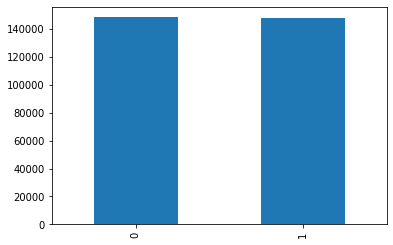

In [27]:
train_data['label'].value_counts().plot(kind = 'bar')

In [28]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label   count
0      0  148245
1      1  147853


In [29]:
print(train_data.isnull().values.any())

True


In [30]:
train_data.loc[train_data.document.isnull()]

,id,document,label,ratings
25857,2172111.0,NaN,1,NaN


In [31]:
train_data = train_data.dropna(subset=['document']) # Null 값이 존재하는 행 제거

In [32]:
print(len(train_data))


296097


In [33]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^A-Za-z0-9ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,id,document,label,ratings
0,9976970.0,아 더빙 진짜 짜증나네요 목소리,0,NaN
1,3819312.0,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1,NaN
2,10265843.0,너무재밓었다그래서보는것을추천한다,0,NaN
3,9045019.0,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0,NaN
4,6483659.0,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1,NaN


In [34]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


id          149915
document       113
label            0
ratings     146182
dtype: int64


In [35]:
train_data = train_data.dropna(subset=['document'])
print(len(train_data))

295984


In [36]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^A-Za-z0-9ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(subset=['document']) # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


전처리 후 테스트용 샘플의 개수 : 99092


In [37]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [38]:
okt = Okt()

X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 295984/295984 [22:45<00:00, 216.83it/s]


In [39]:
len(X_train)

295984

In [40]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 99092/99092 [09:27<00:00, 174.76it/s]


In [41]:
X_test

[['굳다', 'ㅋ'],
 ['GDNTOPCLASSINTHECLUB'],
 ['뭐', '야', '평점', '나쁘다', '않다', '10', '점', '짜다', '리', '더', '더욱', '아니다'],
 ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는'],
 ['3',
  'D',
  '만',
  '아니다',
  '별',
  '다섯',
  '개',
  '주다',
  '왜',
  '3',
  'D',
  '로',
  '나오다',
  '제',
  '심기',
  '불편하다'],
 ['음악', '주가', '되다', '최고', '음악', '영화'],
 ['진정하다', '쓰레기'],
 ['마치',
  '미국',
  '애니',
  '에서',
  '튀어나오다',
  '창의력',
  '없다',
  '로봇',
  '디자인',
  '부터가',
  '고개',
  '젖다'],
 ['갈수록',
  '개판',
  '되다',
  '중국영화',
  '유치하다',
  '내용',
  '없다',
  '폼',
  '잡다',
  '끝나다',
  '말',
  '안되다',
  '무기',
  '유치하다',
  'cg',
  '남무',
  '아',
  '그리다',
  '동사서독',
  '같다',
  '영화',
  '이건',
  '3',
  '류',
  '아',
  '류작',
  '이다'],
 ['이별', '아픔', '뒤', '찾아오다', '새롭다', '인연', '기쁨', 'But', '모든', '사람', '그렇다', '않다'],
 ['괜찮다', '오랜', '만', '포켓몬스터', '잼밌', '어', '요'],
 ['한국', '독립영화', '한계', '그렇게', '아버지', '되다', '비교', '되다'],
 ['청춘',
  '아름답다',
  '그',
  '아름답다',
  '움',
  '이성',
  '을',
  '흔들다',
  '놓다',
  '찰나',
  '아름답다',
  '움',
  '을',
  '자다',
  '포착',
  '섬세하다',
  '아름답다',
  

In [42]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [43]:
print(tokenizer.word_index)


{'보다': 1, '좋다': 2, '영화': 3, '너무': 4, '을': 5, '있다': 6, '없다': 7, '같다': 8, '이다': 9, '요': 10, '배송': 11, '다': 12, '안': 13, '않다': 14, '되다': 15, '자다': 16, '로': 17, '먹다': 18, '만': 19, '아니다': 20, '정말': 21, '재다': 22, '생각': 23, '그냥': 24, '오다': 25, '에서': 26, '것': 27, '구매': 28, '진짜': 29, '쓰다': 30, '못': 31, '고': 32, '적': 33, '더': 34, '때': 35, '사용': 36, '사다': 37, '하고': 38, '받다': 39, '나': 40, '빠르다': 41, '제품': 42, '나오다': 43, '재밌다': 44, '들다': 45, '점': 46, '거': 47, '가격': 48, '많이': 49, '네': 50, 'ㅠㅠ': 51, '그': 52, '별로': 53, '그렇다': 54, '인': 55, '만들다': 56, '개': 57, '게': 58, '맛': 59, '주문': 60, '내': 61, '최고': 62, '보고': 63, '안되다': 64, '모르다': 65, '중': 66, '1': 67, '왜': 68, '서': 69, '하나': 70, '연기': 71, '넘다': 72, '평점': 73, '가다': 74, '괜찮다': 75, '크다': 76, 'ㅋㅋ': 77, '주다': 78, '아': 79, '맞다': 80, '나다': 81, '저': 82, '많다': 83, '사이즈': 84, '사람': 85, '까지': 86, '아깝다': 87, '써다': 88, '이렇다': 89, '인데': 90, '정도': 91, '알다': 92, '말': 93, '만족하다': 94, '포장': 95, 'ㅠ': 96, '맛있다': 97, '수': 98, '다른': 99, '이쁘다': 100, '버리다': 101, '완전': 102,

In [44]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 70423
등장 빈도가 2번 이하인 희귀 단어의 수: 42142
단어 집합에서 희귀 단어의 비율: 59.841245047782685
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.450599532079562


In [45]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
# 단어 집합의 크기 : 43001
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 28282


In [46]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [47]:
print(X_train[:3])

[[79, 910, 29, 379, 1259], [995, 907, 63, 1095, 3, 233, 2238, 71, 1584, 315, 14], [338, 4298, 3627, 4382, 1, 166, 12]]


In [48]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [49]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]


In [50]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

295591
295591


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 70
리뷰의 평균 길이 : 11.552631846030495


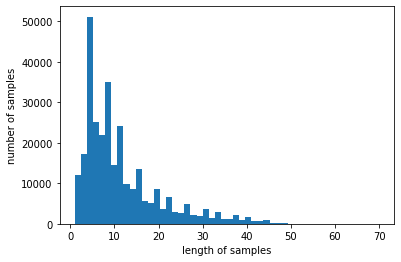

In [51]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [52]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [53]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.38176399146117


In [54]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

## LSTM 감성분석

In [57]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers


embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units, return_sequences=True))
model.add(LSTM(hidden_units, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
3695/3695 [==============================] - ETA: 0s - loss: 0.3481 - acc: 0.8498
Epoch 1: val_acc improved from -inf to 0.89881, saving model to best_model.h5
3695/3695 [==============================] - 632s 169ms/step - loss: 0.3481 - acc: 0.8498 - val_loss: 0.2674 - val_acc: 0.8988
Epoch 2/15
3695/3695 [==============================] - ETA: 0s - loss: 0.2940 - acc: 0.8797
Epoch 2: val_acc improved from 0.89881 to 0.90145, saving model to best_model.h5
3695/3695 [==============================] - 619s 168ms/step - loss: 0.2940 - acc: 0.8797 - val_loss: 0.2576 - val_acc: 0.9015
Epoch 3/15
3695/3695 [==============================] - ETA: 0s - loss: 0.2727 - acc: 0.8905
Epoch 3: val_acc improved from 0.90145 to 0.90414, saving model to best_model.h5
3695/3695 [==============================] - 622s 168ms/step - loss: 0.2727 - acc: 0.8905 - val_loss: 0.2504 - val_acc: 0.9041
Epoch 4/15
3695/3695 [==============================] - ETA: 0s - loss: 0.2573 - acc: 0.8981
Epoch 4

In [58]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

3097/3097 [==============================] - 78s 24ms/step - loss: 0.2893 - acc: 0.8839

 테스트 정확도: 0.8839


# LSTM 관련 시각화

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


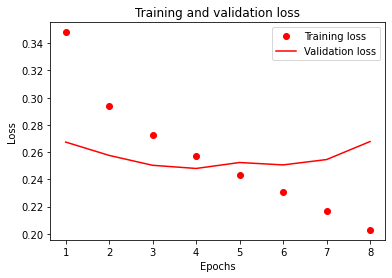

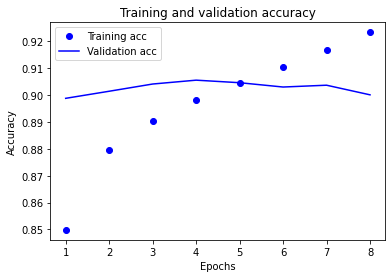

In [59]:
## Loss, Accuracy 그래프 시각화

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'ro', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()